# Importing Required Packages

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set()

# Reading loan_status

In [12]:
loan_status_df_backup = pd.read_csv('Columns/loan_status.csv')
loan_status_df = pd.DataFrame(loan_status_df_backup['loan_status'])

### Unique Values

In [13]:
loan_status_df['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

### Missing Values

In [14]:
loan_status_df['loan_status'].isna().sum()

0

### Creating Dummies

In [15]:
loan_status_df_dummies = pd.DataFrame(np.where(
    (loan_status_df['loan_status'] == 'Current') | (loan_status_df['loan_status'] == 'Fully Paid') | (loan_status_df['loan_status'] == 'Late (16-30 days)') | (loan_status_df['loan_status'] == 'In Grace Period') | (loan_status_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'), 1, 0), 
                                      columns=['loan_status:Not_Default'])

In [16]:
loan_status_df_dummies['loan_status:Not_Default'].unique()

array([1, 0], dtype=int64)

# Splitting into train test sets

In [17]:
train_indices, test_indices, train_targets, test_targets = train_test_split(loan_status_df_dummies.index, loan_status_df_dummies['loan_status:Not_Default'], random_state=42, test_size=0.2)

In [18]:
print("Trainig Indices shape - ", train_indices.shape)
print("Trainig Targets(loan_status:Not_Default) shape - ", train_targets.shape)
print("Testing Indices shape - ", test_indices.shape)
print("Testing Targets(loan_status:Not_Default) shape - ", test_targets.shape)

Trainig Indices shape -  (1808534,)
Trainig Targets(loan_status:Not_Default) shape -  (1808534,)
Testing Indices shape -  (452134,)
Testing Targets(loan_status:Not_Default) shape -  (452134,)


# Preprocessing of Discrete Variables

## Grade

In [19]:
grade_df_backup = pd.read_csv('Columns/grade.csv')
grade_df = pd.DataFrame(grade_df_backup['grade'])

#### Unique Values

In [20]:
grade_df['grade'].unique()

array(['C', 'D', 'B', 'A', 'E', 'F', 'G'], dtype=object)

#### Null Values

In [21]:
grade_df['grade'].isna().sum()

0

#### grade column dummies

In [22]:
grade_df_dummies = pd.get_dummies(grade_df['grade'], prefix='grade', prefix_sep=':')

#### grade column train test split

In [23]:
grade_df_dummies_train, grade_df_dummies_test = grade_df_dummies.iloc[train_indices], grade_df_dummies.iloc[test_indices]

#### grade column WOE DataFrame

In [24]:
grade_woe_df = pd.DataFrame(
    columns=['n_obs', 
             'proba_n_obs', 
             'pos_obs', 
             'proba_pos_obs', 
             'neg_obs', 
             'proba_neg_obs', 
             'woe', 'woe_diff', 
             'iv'], 
    index=grade_df_dummies_train.columns
)

In [25]:
grade_iv = 0
for idx in grade_woe_df.index:
    grade_woe_df.at[idx, 'n_obs'] = grade_df_dummies_train[idx].sum()
    grade_woe_df.at[idx, 'proba_n_obs'] = grade_df_dummies_train[idx].sum() / len(grade_df_dummies_train)
    
    # idx_not_default = list(set(train_targets[train_targets == 1].index).intersection(set(grade_df_dummies_train[grade_df_dummies_train[idx] == 1].index)))
    # idx_default = list(set(train_targets[train_targets == 0].index).intersection(set(grade_df_dummies_train[grade_df_dummies_train[idx] == 1].index)))
    
    idx_not_default = train_targets[train_targets == 1].index
    idx_default = train_targets[train_targets == 0].index
    
    grade_woe_df.at[idx, 'pos_obs'] = grade_df_dummies_train.loc[idx_not_default][idx].sum()
    grade_woe_df.at[idx, 'proba_pos_obs'] = grade_df_dummies_train.loc[idx_not_default][idx].sum() / len(idx_not_default)
    
    grade_woe_df.at[idx, 'neg_obs'] = grade_df_dummies_train.loc[idx_default][idx].sum()
    grade_woe_df.at[idx, 'proba_neg_obs'] = grade_df_dummies_train.loc[idx_default][idx].sum() / len(idx_default)
    
    grade_woe_df.at[idx, 'woe'] = np.log(grade_woe_df.at[idx, 'proba_pos_obs'] / grade_woe_df.at[idx, 'proba_neg_obs'])
    grade_iv = grade_iv + ((grade_woe_df.at[idx, 'proba_pos_obs'] - grade_woe_df.at[idx, 'proba_neg_obs']) * grade_woe_df.at[idx, 'woe'])

In [26]:
grade_woe_df.sort_values(by=['woe'], axis=0, inplace=True)

In [27]:
grade_woe_df['woe_diff'] = grade_woe_df['woe'].diff(1)

In [28]:
grade_woe_df['iv'] = grade_iv

In [29]:
grade_woe_df

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
grade:G,9691,0.00535848,5852,0.00370086,3839,0.0168911,-1.51822,NaN,0.482686
grade:F,33629,0.0185946,21476,0.0135816,12153,0.0534717,-1.37044,0.147788,0.482686
grade:E,108133,0.0597904,78022,0.0493418,30111,0.132485,-0.987695,0.38274,0.482686
grade:D,259610,0.143547,208050,0.131573,51560,0.226858,-0.544764,0.442932,0.482686
grade:C,519884,0.287462,447001,0.282687,72883,0.320676,-0.12609,0.418673,0.482686
grade:B,531082,0.293653,486387,0.307596,44695,0.196653,0.447347,0.573438,0.482686
grade:A,346505,0.191594,334467,0.21152,12038,0.0529657,1.38467,0.937327,0.482686


#### Plotting WOEs for all categories of grade column

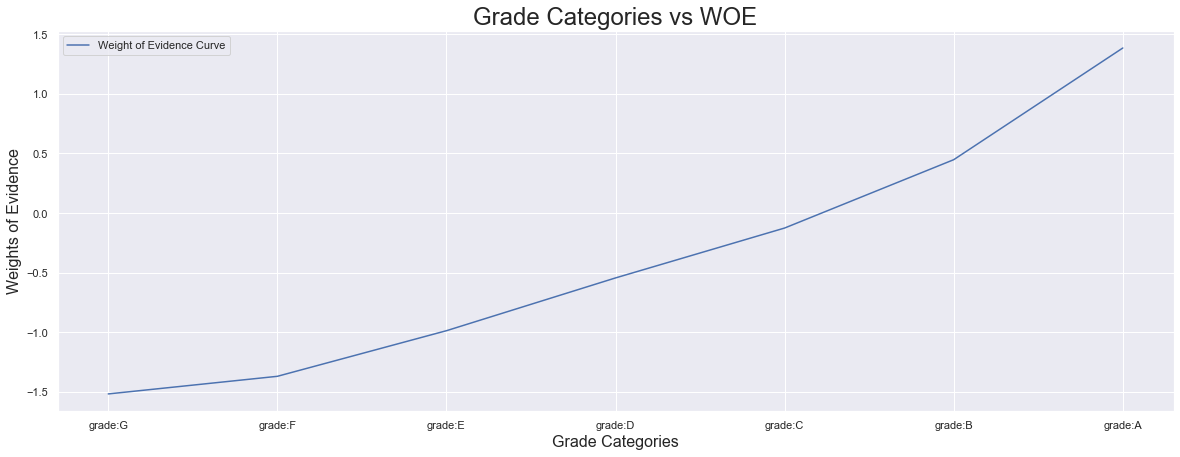

In [30]:
plt.rcParams['figure.figsize'] = 20, 7

plt.plot(grade_woe_df['woe'], label='Weight of Evidence Curve')

plt.title('Grade Categories vs WOE', size=24)
plt.xlabel('Grade Categories', size=16)
plt.ylabel('Weights of Evidence', size=16)

plt.legend()
plt.show()

# WOE Function

In [31]:
def woe_graph(df, feature_name, rot_angle=0):
    plt.rcParams['figure.figsize'] = 20, 7

    plt.plot(df, label='Weight of Evidence Curve', marker='o', linestyle='--', color='k')

    plt.title(str(feature_name)+' Categories vs WOE', size=24)
    plt.xlabel(str(feature_name)+' Categories', size=16)
    plt.ylabel('Weights of Evidence', size=16)
    
    plt.xticks(rotation=rot_angle)

    plt.legend()
    plt.show()

In [32]:
def calc_woe_df(df, train_targets, feature_name, rot_angle=0):
    
    woe_df = pd.DataFrame(
        columns=['n_obs', 
                 'proba_n_obs', 
                 'pos_obs', 
                 'proba_pos_obs', 
                 'neg_obs', 
                 'proba_neg_obs', 
                 'woe', 'woe_diff', 
                 'iv'], 
        index=df.columns
    )
    
    iv = 0
    for idx in woe_df.index:
        woe_df.at[idx, 'n_obs'] = df[idx].sum()
        woe_df.at[idx, 'proba_n_obs'] = df[idx].sum() / len(df)
        
        idx_not_default = train_targets[train_targets == 1].index
        idx_default = train_targets[train_targets == 0].index

        woe_df.at[idx, 'pos_obs'] = df.loc[idx_not_default][idx].sum()
        woe_df.at[idx, 'proba_pos_obs'] = df.loc[idx_not_default][idx].sum() / len(idx_not_default)

        woe_df.at[idx, 'neg_obs'] = df.loc[idx_default][idx].sum()
        woe_df.at[idx, 'proba_neg_obs'] = df.loc[idx_default][idx].sum() / len(idx_default)

        woe_df.at[idx, 'woe'] = np.log(woe_df.at[idx, 'proba_pos_obs'] / woe_df.at[idx, 'proba_neg_obs'])
        iv = iv + ((woe_df.at[idx, 'proba_pos_obs'] - woe_df.at[idx, 'proba_neg_obs']) * woe_df.at[idx, 'woe'])
    
    woe_df.sort_values(by=['woe'], axis=0, inplace=True)
    woe_df['woe_diff'] = woe_df['woe'].diff(1)
    woe_df['iv'] = iv
    
    woe_graph(woe_df['woe'], feature_name, rot_angle)
    return woe_df

#### Testing the function on precomputed WOEs of grade

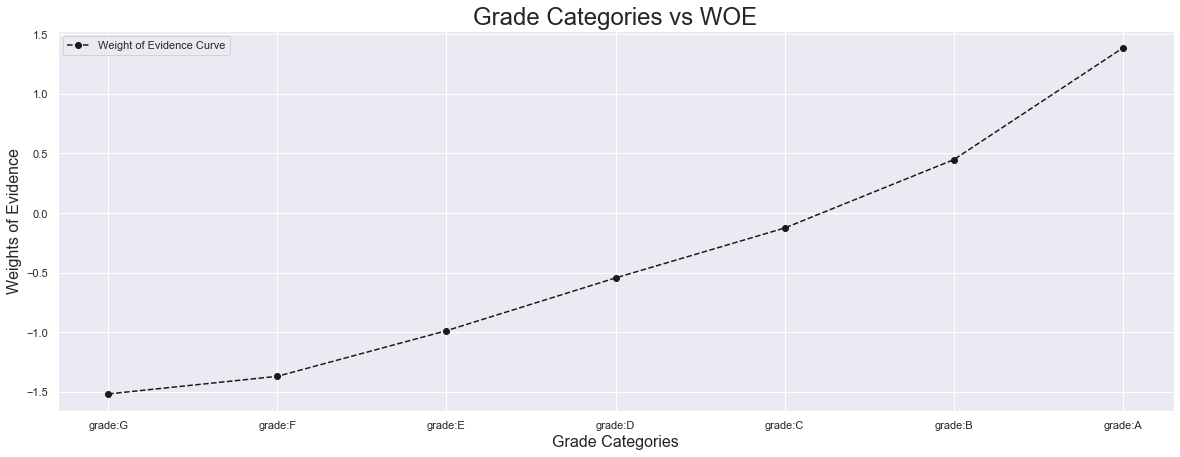

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
grade:G,9691,0.00535848,5852,0.00370086,3839,0.0168911,-1.51822,NaN,0.482686
grade:F,33629,0.0185946,21476,0.0135816,12153,0.0534717,-1.37044,0.147788,0.482686
grade:E,108133,0.0597904,78022,0.0493418,30111,0.132485,-0.987695,0.38274,0.482686
grade:D,259610,0.143547,208050,0.131573,51560,0.226858,-0.544764,0.442932,0.482686
grade:C,519884,0.287462,447001,0.282687,72883,0.320676,-0.12609,0.418673,0.482686
grade:B,531082,0.293653,486387,0.307596,44695,0.196653,0.447347,0.573438,0.482686
grade:A,346505,0.191594,334467,0.21152,12038,0.0529657,1.38467,0.937327,0.482686


In [33]:
calc_woe_df(grade_df_dummies_train, train_targets, 'Grade')

#### Adding grade feature to the set of training features

In [34]:
training_features_df = pd.DataFrame(index=train_indices)

In [35]:
training_features_df = pd.concat((training_features_df, grade_df_dummies_train), axis=1)

#### Adding grade feature to the set of testing features

In [36]:
testing_features_df = pd.DataFrame(index=test_indices)

In [37]:
testing_features_df = pd.concat((testing_features_df, grade_df_dummies_test), axis=1)

## Home Ownership

In [38]:
home_ownership_df_backup = pd.read_csv('Columns/home_ownership.csv')
home_ownership_df = home_ownership_df_backup[['home_ownership']]

#### Unique Values

In [39]:
home_ownership_df['home_ownership'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY', 'NONE', 'OTHER'], dtype=object)

#### Null Values

In [40]:
home_ownership_df['home_ownership'].isna().sum()

0

#### home_ownership column dummies

In [41]:
home_ownership_df_dummies = pd.get_dummies(home_ownership_df['home_ownership'], prefix='home_ownership', prefix_sep=':')

#### home_ownership column train test split

In [42]:
home_ownership_df_dummies_train, home_ownership_df_dummies_test = home_ownership_df_dummies.iloc[train_indices], home_ownership_df_dummies.iloc[test_indices]

#### home_ownership column WOE dataframe and plot

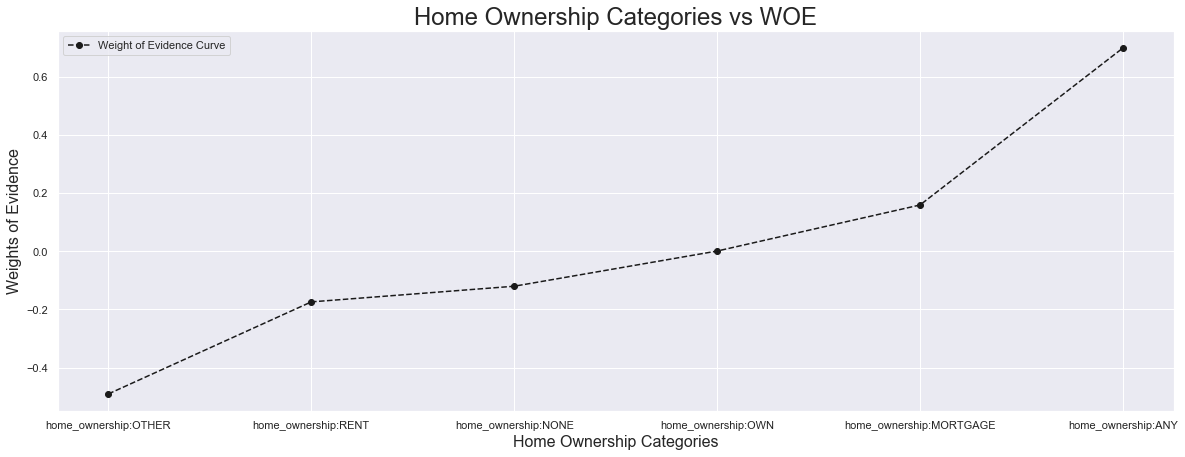

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
home_ownership:OTHER,142,7.85166e-05,115,7.2727e-05,27,0.000118797,-0.490701,NaN,0.024684
home_ownership:RENT,715761,0.395769,611174,0.386512,104587,0.46017,-0.174433,0.316267,0.024684
home_ownership:NONE,43,2.37762e-05,37,2.33991e-05,6,2.63993e-05,-0.120637,0.053796,0.024684
home_ownership:OWN,202560,0.112002,177110,0.112006,25450,0.111977,0.000259489,0.120897,0.024684
home_ownership:MORTGAGE,889204,0.491671,792050,0.5009,97154,0.427466,0.158531,0.158272,0.024684
home_ownership:ANY,824,0.000455618,769,0.000486323,55,0.000241993,0.697962,0.539431,0.024684


In [43]:
calc_woe_df(home_ownership_df_dummies_train, train_targets, 'Home Ownership')

#### Training Features of home_ownership column

In [44]:
home_ownership_training_features_df = home_ownership_df_dummies_train[['home_ownership:OTHER']]

home_ownership_training_features_df['home_ownership:RENT_NONE_OWN'] = np.where( ((home_ownership_df_dummies_train['home_ownership:RENT'] == 1) | (home_ownership_df_dummies_train['home_ownership:NONE'] == 1) | (home_ownership_df_dummies_train['home_ownership:OWN'] == 1)), 1, 0)
home_ownership_training_features_df['home_ownership:MORTGAGE'] = home_ownership_df_dummies_train['home_ownership:MORTGAGE']
home_ownership_training_features_df['home_ownership:ANY'] = home_ownership_df_dummies_train['home_ownership:ANY']

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is t

#### Testing Features of home_ownership column

In [45]:
home_ownership_testing_features_df = home_ownership_df_dummies_test[['home_ownership:OTHER']]

home_ownership_testing_features_df['home_ownership:RENT_NONE_OWN'] = np.where( ((home_ownership_df_dummies_test['home_ownership:RENT'] == 1) | (home_ownership_df_dummies_test['home_ownership:NONE'] == 1) | (home_ownership_df_dummies_test['home_ownership:OWN'] == 1)), 1, 0)
home_ownership_testing_features_df['home_ownership:MORTGAGE'] = home_ownership_df_dummies_test['home_ownership:MORTGAGE']
home_ownership_testing_features_df['home_ownership:ANY'] = home_ownership_df_dummies_test['home_ownership:ANY']

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is t

#### Adding home_ownership feature to the set of training and testing features

In [46]:
training_features_df = pd.concat((training_features_df, home_ownership_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, home_ownership_testing_features_df), axis=1)

## Address State

In [47]:
addr_state_df_backup = pd.read_csv('Columns/addr_state.csv')
addr_state_df = addr_state_df_backup[['addr_state']]

#### US States

In [48]:
us_states_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                  'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                  'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                  'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                  'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY',
                  'DC']
len(us_states_list)

51

#### Unique Values

In [49]:
len(addr_state_df['addr_state'].unique())

51

#### Missing States

In [50]:
set(us_states_list) - set(us_states_list).intersection(set(addr_state_df['addr_state'].unique()))

set()

#### Null Values

In [51]:
addr_state_df['addr_state'].isna().sum()

0

#### addr_state column dummies

In [52]:
addr_state_df_dummies = pd.get_dummies(addr_state_df['addr_state'], prefix='addr_state', prefix_sep=':')

#### addr_state column train test split

In [53]:
addr_state_df_dummies_train, addr_state_df_dummies_test = addr_state_df_dummies.iloc[train_indices], addr_state_df_dummies.iloc[test_indices]

#### addr_state column WOE dataframe and plot

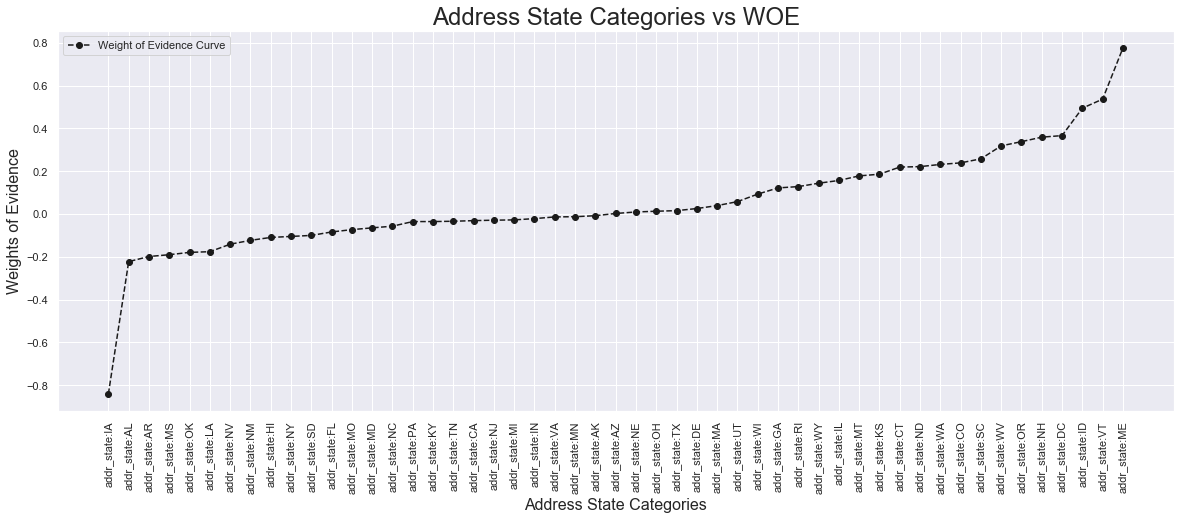

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
addr_state:IA,12,6.63521e-06,9,5.69168e-06,3,1.31996e-05,-0.841183,NaN,0.014338
addr_state:AL,21792,0.0120495,18474,0.0116831,3318,0.0145988,-0.222794,0.61839,0.014338
addr_state:AR,13572,0.00750442,11547,0.00730243,2025,0.00890975,-0.19894,0.0238538,0.014338
addr_state:MS,10065,0.00556528,8574,0.00542228,1491,0.00656022,-0.190508,0.00843137,0.014338
addr_state:OK,16515,0.00913171,14091,0.00891128,2424,0.0106653,-0.179679,0.0108299,0.014338
addr_state:LA,20517,0.0113445,17514,0.011076,3003,0.0132128,-0.176407,0.00327154,0.014338
addr_state:NV,26116,0.0144404,22406,0.0141698,3710,0.0163235,-0.141499,0.0349081,0.014338
addr_state:NM,9623,0.00532088,8277,0.00523445,1346,0.00592224,-0.123452,0.0180464,0.014338
addr_state:HI,8558,0.00473201,7375,0.00466402,1183,0.00520506,-0.109753,0.013699,0.014338
addr_state:NY,149066,0.0824237,128541,0.0812905,20525,0.0903075,-0.105192,0.00456195,0.014338


In [54]:
calc_woe_df(addr_state_df_dummies_train, train_targets, 'Address State', 90)

#### Training Features of addr_state column

In [55]:
addr_state_training_features_df = addr_state_df_dummies_train[['addr_state:IA']]
addr_state_training_features_df['addr_state:AL_AR_MS_OK_LA_NV_NM_HI'] = np.where( ((addr_state_df_dummies_train['addr_state:AL'] == 1)| (addr_state_df_dummies_train['addr_state:AR'] == 1)| (addr_state_df_dummies_train['addr_state:MS'] == 1)| (addr_state_df_dummies_train['addr_state:OK'] == 1)| (addr_state_df_dummies_train['addr_state:LA'] == 1)| (addr_state_df_dummies_train['addr_state:NV'] == 1)| (addr_state_df_dummies_train['addr_state:NM'] == 1) | (addr_state_df_dummies_train['addr_state:HI'] == 1)), 1, 0)
addr_state_training_features_df['addr_state:NY'] = addr_state_df_dummies_train[['addr_state:NY']]
addr_state_training_features_df['addr_state:SD'] = addr_state_df_dummies_train[['addr_state:SD']]
addr_state_training_features_df['addr_state:FL'] = addr_state_df_dummies_train[['addr_state:FL']]
addr_state_training_features_df['addr_state:MO_MD_NC_PA_KY_TN'] = np.where( ((addr_state_df_dummies_train['addr_state:MO'] == 1)| (addr_state_df_dummies_train['addr_state:MD'] == 1)| (addr_state_df_dummies_train['addr_state:NC'] == 1)| (addr_state_df_dummies_train['addr_state:PA'] == 1)| (addr_state_df_dummies_train['addr_state:KY'] == 1)| (addr_state_df_dummies_train['addr_state:TN'] == 1)), 1, 0)
addr_state_training_features_df['addr_state:CA'] = addr_state_df_dummies_train[['addr_state:CA']]
addr_state_training_features_df['addr_state:NJ_MI_VA_MN_AK_AZ_NE_OH'] = np.where( ((addr_state_df_dummies_train['addr_state:NJ'] == 1)| (addr_state_df_dummies_train['addr_state:MI'] == 1)| (addr_state_df_dummies_train['addr_state:VA'] == 1)| (addr_state_df_dummies_train['addr_state:MN'] == 1)| (addr_state_df_dummies_train['addr_state:AK'] == 1)| (addr_state_df_dummies_train['addr_state:AZ'] == 1)| (addr_state_df_dummies_train['addr_state:NE'] == 1)| (addr_state_df_dummies_train['addr_state:OH'] == 1)), 1, 0)
addr_state_training_features_df['addr_state:TX'] = addr_state_df_dummies_train[['addr_state:TX']]
addr_state_training_features_df['addr_state:DE_MA_UT_GA_RI_WY_IL_MT_KS'] = np.where( ((addr_state_df_dummies_train['addr_state:DE'] == 1)| (addr_state_df_dummies_train['addr_state:MA'] == 1)| (addr_state_df_dummies_train['addr_state:UT'] == 1)| (addr_state_df_dummies_train['addr_state:GA'] == 1)| (addr_state_df_dummies_train['addr_state:RI'] == 1)| (addr_state_df_dummies_train['addr_state:WY'] == 1)| (addr_state_df_dummies_train['addr_state:IL'] == 1)| (addr_state_df_dummies_train['addr_state:MT'] == 1)| (addr_state_df_dummies_train['addr_state:KS'] == 1)), 1, 0)
addr_state_training_features_df['addr_state:CT_ND_WA_CO_SC_WV_OR_NH_DC'] = np.where( ((addr_state_df_dummies_train['addr_state:CT'] == 1)| (addr_state_df_dummies_train['addr_state:ND'] == 1)| (addr_state_df_dummies_train['addr_state:WA'] == 1)| (addr_state_df_dummies_train['addr_state:CO'] == 1)| (addr_state_df_dummies_train['addr_state:SC'] == 1)| (addr_state_df_dummies_train['addr_state:WV'] == 1)| (addr_state_df_dummies_train['addr_state:OR'] == 1)| (addr_state_df_dummies_train['addr_state:NH'] == 1)| (addr_state_df_dummies_train['addr_state:DC'] == 1)), 1, 0)
addr_state_training_features_df['addr_state:ID_VT'] = np.where( ((addr_state_df_dummies_train['addr_state:ID'] == 1) | (addr_state_df_dummies_train['addr_state:VT'] == 1)), 1, 0)
addr_state_training_features_df['addr_state:ME'] = addr_state_df_dummies_train[['addr_state:ME']]

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

#### Testing Features of addr_state column

In [56]:
addr_state_testing_features_df = addr_state_df_dummies_test[['addr_state:IA']]
addr_state_testing_features_df['addr_state:AL_AR_MS_OK_LA_NV_NM_HI'] = np.where( ((addr_state_df_dummies_test['addr_state:AL'] == 1)| (addr_state_df_dummies_test['addr_state:AR'] == 1)| (addr_state_df_dummies_test['addr_state:MS'] == 1)| (addr_state_df_dummies_test['addr_state:OK'] == 1)| (addr_state_df_dummies_test['addr_state:LA'] == 1)| (addr_state_df_dummies_test['addr_state:NV'] == 1)| (addr_state_df_dummies_test['addr_state:NM'] == 1) | (addr_state_df_dummies_test['addr_state:HI'] == 1)), 1, 0)
addr_state_testing_features_df['addr_state:NY'] = addr_state_df_dummies_test[['addr_state:NY']]
addr_state_testing_features_df['addr_state:SD'] = addr_state_df_dummies_test[['addr_state:SD']]
addr_state_testing_features_df['addr_state:FL'] = addr_state_df_dummies_test[['addr_state:FL']]
addr_state_testing_features_df['addr_state:MO_MD_NC_PA_KY_TN'] = np.where( ((addr_state_df_dummies_test['addr_state:MO'] == 1)| (addr_state_df_dummies_test['addr_state:MD'] == 1)| (addr_state_df_dummies_test['addr_state:NC'] == 1)| (addr_state_df_dummies_test['addr_state:PA'] == 1)| (addr_state_df_dummies_test['addr_state:KY'] == 1)| (addr_state_df_dummies_test['addr_state:TN'] == 1)), 1, 0)
addr_state_testing_features_df['addr_state:CA'] = addr_state_df_dummies_test[['addr_state:CA']]
addr_state_testing_features_df['addr_state:NJ_MI_VA_MN_AK_AZ_NE_OH'] = np.where( ((addr_state_df_dummies_test['addr_state:NJ'] == 1)| (addr_state_df_dummies_test['addr_state:MI'] == 1)| (addr_state_df_dummies_test['addr_state:VA'] == 1)| (addr_state_df_dummies_test['addr_state:MN'] == 1)| (addr_state_df_dummies_test['addr_state:AK'] == 1)| (addr_state_df_dummies_test['addr_state:AZ'] == 1)| (addr_state_df_dummies_test['addr_state:NE'] == 1)| (addr_state_df_dummies_test['addr_state:OH'] == 1)), 1, 0)
addr_state_testing_features_df['addr_state:TX'] = addr_state_df_dummies_test[['addr_state:TX']]
addr_state_testing_features_df['addr_state:DE_MA_UT_GA_RI_WY_IL_MT_KS'] = np.where( ((addr_state_df_dummies_test['addr_state:DE'] == 1)| (addr_state_df_dummies_test['addr_state:MA'] == 1)| (addr_state_df_dummies_test['addr_state:UT'] == 1)| (addr_state_df_dummies_test['addr_state:GA'] == 1)| (addr_state_df_dummies_test['addr_state:RI'] == 1)| (addr_state_df_dummies_test['addr_state:WY'] == 1)| (addr_state_df_dummies_test['addr_state:IL'] == 1)| (addr_state_df_dummies_test['addr_state:MT'] == 1)| (addr_state_df_dummies_test['addr_state:KS'] == 1)), 1, 0)
addr_state_testing_features_df['addr_state:CT_ND_WA_CO_SC_WV_OR_NH_DC'] = np.where( ((addr_state_df_dummies_test['addr_state:CT'] == 1)| (addr_state_df_dummies_test['addr_state:ND'] == 1)| (addr_state_df_dummies_test['addr_state:WA'] == 1)| (addr_state_df_dummies_test['addr_state:CO'] == 1)| (addr_state_df_dummies_test['addr_state:SC'] == 1)| (addr_state_df_dummies_test['addr_state:WV'] == 1)| (addr_state_df_dummies_test['addr_state:OR'] == 1)| (addr_state_df_dummies_test['addr_state:NH'] == 1)| (addr_state_df_dummies_test['addr_state:DC'] == 1)), 1, 0)
addr_state_testing_features_df['addr_state:ID_VT'] = np.where( ((addr_state_df_dummies_test['addr_state:ID'] == 1) | (addr_state_df_dummies_test['addr_state:VT'] == 1)), 1, 0)
addr_state_testing_features_df['addr_state:ME'] = addr_state_df_dummies_test[['addr_state:ME']]

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

#### Adding addr_state feature to the set of training and testing features

In [57]:
training_features_df = pd.concat((training_features_df, addr_state_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, addr_state_testing_features_df), axis=1)

## Verification Status

In [65]:
verification_status_df_backup = pd.read_csv('Columns/verification_status.csv')
verification_status_df = verification_status_df_backup[['verification_status']]

#### Unique Values

In [67]:
verification_status_df['verification_status'].unique()

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

#### Null Values

In [68]:
verification_status_df['verification_status'].isna().sum()

0

#### verification_status column dummies

In [69]:
verification_status_df_dummies = pd.get_dummies(verification_status_df['verification_status'], prefix='verification_status', prefix_sep=':')

#### verification_status column train test split

In [70]:
verification_status_df_dummies_train, verification_status_df_dummies_test = verification_status_df_dummies.iloc[train_indices], verification_status_df_dummies.iloc[test_indices]

#### verification_status column WOE dataframe and plot

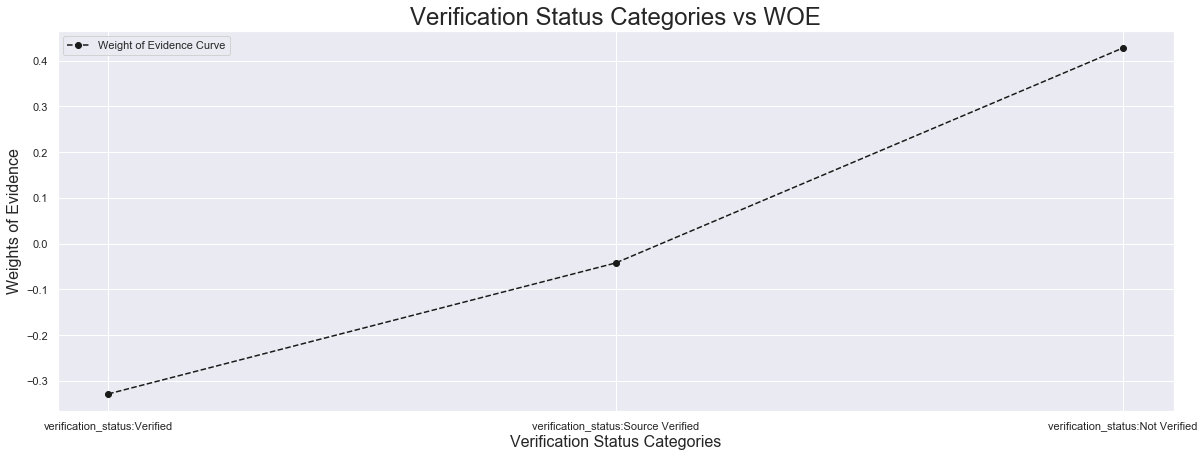

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
verification_status:Verified,503341,0.278314,419588,0.265351,83753,0.368503,-0.328394,NaN,0.085899
verification_status:Source Verified,708836,0.39194,616411,0.389824,92425,0.406659,-0.0422793,0.286115,0.085899
verification_status:Not Verified,596357,0.329746,545256,0.344825,51101,0.224838,0.427656,0.469935,0.085899


In [71]:
calc_woe_df(verification_status_df_dummies_train, train_targets, 'Verification Status')

#### Training Features of verification_status column

In [72]:
verification_status_training_features_df = verification_status_df_dummies_train[['verification_status:Verified']]
verification_status_training_features_df['verification_status:Source Verified'] = verification_status_df_dummies_train['verification_status:Source Verified']
verification_status_training_features_df['verification_status:Not Verified'] = verification_status_df_dummies_train['verification_status:Not Verified']

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Testing Features of verification_status column

In [73]:
verification_status_testing_features_df = verification_status_df_dummies_test[['verification_status:Verified']]
verification_status_testing_features_df['verification_status:Source Verified'] = verification_status_df_dummies_test['verification_status:Source Verified']
verification_status_testing_features_df['verification_status:Not Verified'] = verification_status_df_dummies_test['verification_status:Not Verified']

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Adding verification_status feature to the set of training and testing features

In [74]:
training_features_df = pd.concat((training_features_df, verification_status_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, verification_status_testing_features_df), axis=1)

In [77]:
training_features_df.columns

Index(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'grade:G', 'home_ownership:OTHER', 'home_ownership:RENT_NONE_OWN',
       'home_ownership:MORTGAGE', 'home_ownership:ANY', 'addr_state:IA',
       'addr_state:AL_AR_MS_OK_LA_NV_NM_HI', 'addr_state:NY', 'addr_state:SD',
       'addr_state:FL', 'addr_state:MO_MD_NC_PA_KY_TN', 'addr_state:CA',
       'addr_state:NJ_MI_VA_MN_AK_AZ_NE_OH', 'addr_state:TX',
       'addr_state:DE_MA_UT_GA_RI_WY_IL_MT_KS',
       'addr_state:CT_ND_WA_CO_SC_WV_OR_NH_DC', 'addr_state:ID_VT',
       'addr_state:ME', 'verification_status:Verified',
       'verification_status:Source Verified',
       'verification_status:Not Verified'],
      dtype='object')

## Purpose

In [78]:
purpose_df_backup = pd.read_csv('Columns/purpose.csv')
purpose_df = purpose_df_backup[['purpose']]

#### Unique Values

In [80]:
purpose_df['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'house', 'car', 'other',
       'vacation', 'home_improvement', 'small_business', 'major_purchase',
       'medical', 'renewable_energy', 'moving', 'wedding', 'educational'],
      dtype=object)

#### Null Values

In [81]:
purpose_df['purpose'].isna().sum()

0

#### purpose column dummies

In [82]:
purpose_df_dummies = pd.get_dummies(purpose_df['purpose'], prefix='purpose', prefix_sep=':')

#### purpose column train test split

In [83]:
purpose_df_dummies_train, purpose_df_dummies_test = purpose_df_dummies.iloc[train_indices], purpose_df_dummies.iloc[test_indices]

#### purpose column WOE dataframe and plot

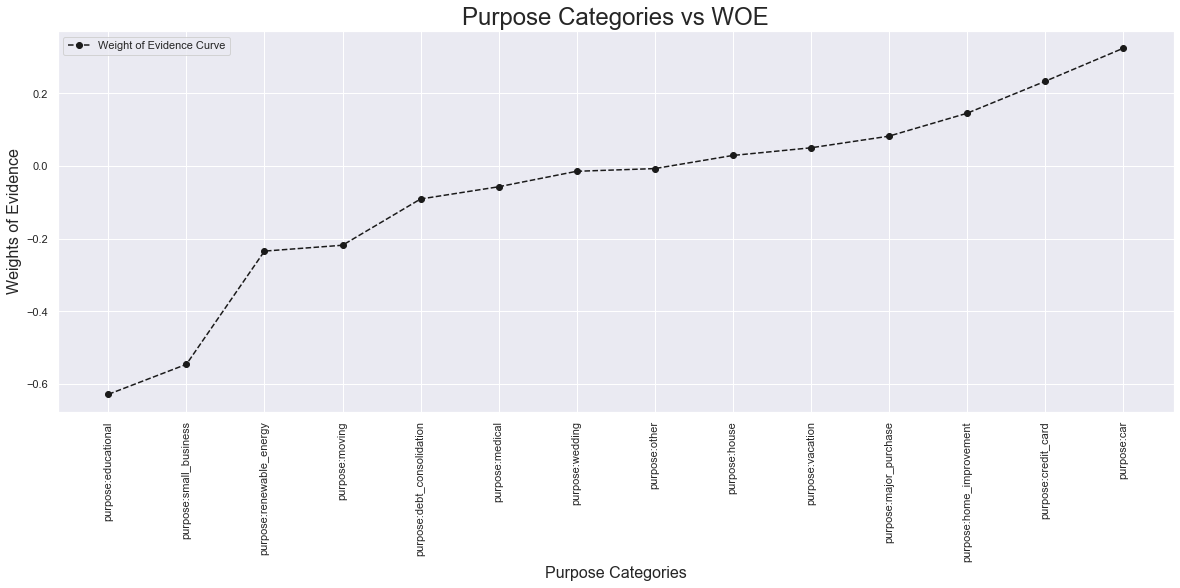

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
purpose:educational,344,0.000190209,271,0.000171383,73,0.000321191,-0.628136,NaN,0.023151
purpose:small_business,19765,0.0109287,15837,0.0100155,3928,0.0172827,-0.545577,0.0825592,0.023151
purpose:renewable_energy,1145,0.000633109,969,0.000612804,176,0.000774379,-0.234015,0.311562,0.023151
purpose:moving,12419,0.00686689,10536,0.00666306,1883,0.00828497,-0.217864,0.0161511,0.023151
purpose:debt_consolidation,1022358,0.565297,883354,0.558641,139004,0.611601,-0.0905725,0.127292,0.023151
purpose:medical,21975,0.0121507,19073,0.0120619,2902,0.0127684,-0.0569222,0.0336503,0.023151
purpose:wedding,1886,0.00104283,1646,0.00104095,240,0.00105597,-0.0143313,0.0425909,0.023151
purpose:other,111451,0.0616251,97360,0.0615713,14091,0.0619987,-0.00691662,0.0074147,0.023151
purpose:house,11266,0.00622935,9886,0.006252,1380,0.00607183,0.0292403,0.036157,0.023151
purpose:vacation,12391,0.00685141,10901,0.00689389,1490,0.00655582,0.0502826,0.0210423,0.023151


In [85]:
calc_woe_df(purpose_df_dummies_train, train_targets, 'Purpose', 90)

#### Training Features of purpose column

In [86]:
purpose_training_features_df = purpose_df_dummies_train[['purpose:debt_consolidation']]
purpose_training_features_df['purpose:educational_small_business'] = np.where( ((purpose_df_dummies_train['purpose:educational'] == 1) | (purpose_df_dummies_train['purpose:small_business'] == 1)), 1, 0)
purpose_training_features_df['purpose:renewable_energy_moving'] = np.where( ((purpose_df_dummies_train['purpose:renewable_energy'] == 1) | (purpose_df_dummies_train['purpose:moving'] == 1)), 1, 0)
purpose_training_features_df['purpose:medical_wedding'] = np.where( ((purpose_df_dummies_train['purpose:medical'] == 1) | (purpose_df_dummies_train['purpose:wedding'] == 1)), 1, 0)
purpose_training_features_df['purpose:other'] = purpose_df_dummies_train[['purpose:other']]
purpose_training_features_df['purpose:house_vacation_major_purchase'] = np.where( ((purpose_df_dummies_train['purpose:house'] == 1) | (purpose_df_dummies_train['purpose:vacation'] == 1) | (purpose_df_dummies_train['purpose:major_purchase'] == 1)), 1, 0)
purpose_training_features_df['purpose:home_improvement'] = purpose_df_dummies_train[['purpose:home_improvement']]
purpose_training_features_df['purpose:credit_card'] = purpose_df_dummies_train[['purpose:credit_card']]
purpose_training_features_df['purpose:car'] = purpose_df_dummies_train[['purpose:car']]

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

#### Testing Features of purpose column

In [87]:
purpose_testing_features_df = purpose_df_dummies_test[['purpose:debt_consolidation']]
purpose_testing_features_df['purpose:educational_small_business'] = np.where( ((purpose_df_dummies_test['purpose:educational'] == 1) | (purpose_df_dummies_test['purpose:small_business'] == 1)), 1, 0)
purpose_testing_features_df['purpose:renewable_energy_moving'] = np.where( ((purpose_df_dummies_test['purpose:renewable_energy'] == 1) | (purpose_df_dummies_test['purpose:moving'] == 1)), 1, 0)
purpose_testing_features_df['purpose:medical_wedding'] = np.where( ((purpose_df_dummies_test['purpose:medical'] == 1) | (purpose_df_dummies_test['purpose:wedding'] == 1)), 1, 0)
purpose_testing_features_df['purpose:other'] = purpose_df_dummies_test[['purpose:other']]
purpose_testing_features_df['purpose:house_vacation_major_purchase'] = np.where( ((purpose_df_dummies_test['purpose:house'] == 1) | (purpose_df_dummies_test['purpose:vacation'] == 1) | (purpose_df_dummies_test['purpose:major_purchase'] == 1)), 1, 0)
purpose_testing_features_df['purpose:home_improvement'] = purpose_df_dummies_test[['purpose:home_improvement']]
purpose_testing_features_df['purpose:credit_card'] = purpose_df_dummies_test[['purpose:credit_card']]
purpose_testing_features_df['purpose:car'] = purpose_df_dummies_test[['purpose:car']]

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

#### Adding purpose feature to the set of training and testing features

In [88]:
training_features_df = pd.concat((training_features_df, purpose_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, purpose_testing_features_df), axis=1)

## Initial List Status

In [93]:
initial_list_status_df_backup = pd.read_csv('Columns/initial_list_status.csv')
initial_list_status_df = initial_list_status_df_backup[['initial_list_status']]

#### Unique Values

In [95]:
initial_list_status_df['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

#### Null Values

In [96]:
initial_list_status_df['initial_list_status'].isna().sum()

0

#### initial_list_status column dummies

In [97]:
initial_list_status_df_dummies = pd.get_dummies(initial_list_status_df['initial_list_status'], prefix='initial_list_status', prefix_sep=':')

#### initial_list_status column train test split

In [98]:
initial_list_status_df_dummies_train, initial_list_status_df_dummies_test = initial_list_status_df_dummies.iloc[train_indices], initial_list_status_df_dummies.iloc[test_indices]

#### initial_list_status column WOE dataframe and plot

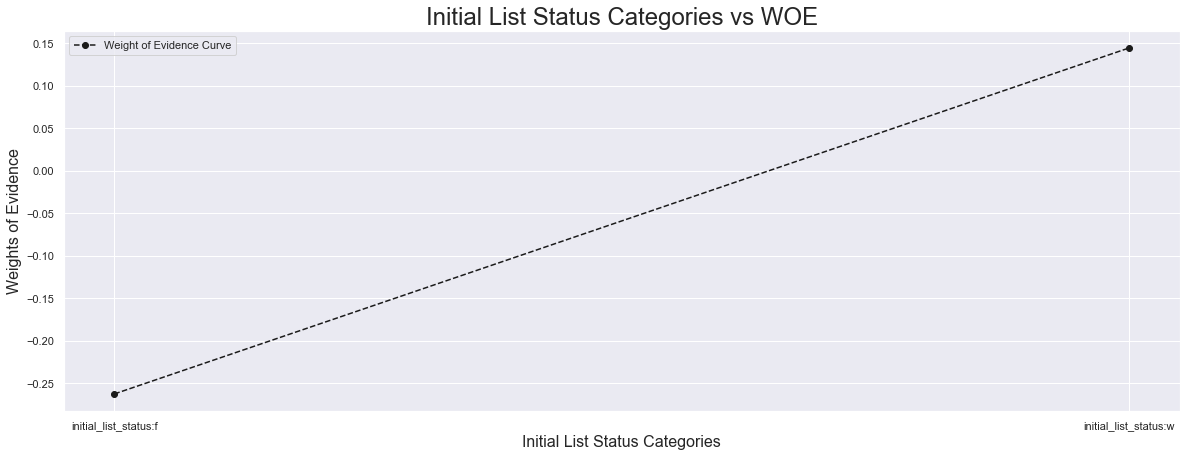

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
initial_list_status:f,580462,0.320957,489063,0.309288,91399,0.402145,-0.262539,NaN,0.037785
initial_list_status:w,1228072,0.679043,1092192,0.690712,135880,0.597855,0.144374,0.406913,0.037785


In [99]:
calc_woe_df(initial_list_status_df_dummies_train, train_targets, 'Initial List Status')

#### Training Features of initial_list_status column

In [100]:
initial_list_status_training_features_df = initial_list_status_df_dummies_train[['initial_list_status:f']]
initial_list_status_training_features_df['initial_list_status:w'] = initial_list_status_df_dummies_train[['initial_list_status:w']]

#### Testing Features of initial_list_status column

In [101]:
initial_list_status_testing_features_df = initial_list_status_df_dummies_test[['initial_list_status:f']]
initial_list_status_testing_features_df['initial_list_status:w'] = initial_list_status_df_dummies_test[['initial_list_status:w']]

#### Adding initial_list_status feature to the set of training and testing features

In [102]:
training_features_df = pd.concat((training_features_df, initial_list_status_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, initial_list_status_testing_features_df), axis=1)

# Exporting Final Preprocessed Dataframe

In [104]:
training_features_df.to_csv('training_features_df.csv', index=True)
testing_features_df.to_csv('testing_features_df.csv', index=True)

In [105]:
training_features_df_imported = pd.read_csv('training_features_df.csv')
testing_features_df_imported = pd.read_csv('testing_features_df.csv')

In [106]:
training_features_df = training_features_df_imported.copy()
training_features_df.set_index('Unnamed: 0', inplace=True)

testing_features_df = testing_features_df_imported.copy()
testing_features_df.set_index('Unnamed: 0', inplace=True)

In [107]:
training_features_df

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:OTHER,home_ownership:RENT_NONE_OWN,home_ownership:MORTGAGE,...,purpose:educational_small_business,purpose:renewable_energy_moving,purpose:medical_wedding,purpose:other,purpose:house_vacation_major_purchase,purpose:home_improvement,purpose:credit_card,purpose:car,initial_list_status:f,initial_list_status:w
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
305053,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
50247,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1630001,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
927626,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
758488,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732180,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
110268,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1692743,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [108]:
testing_features_df

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:OTHER,home_ownership:RENT_NONE_OWN,home_ownership:MORTGAGE,...,purpose:educational_small_business,purpose:renewable_energy_moving,purpose:medical_wedding,purpose:other,purpose:house_vacation_major_purchase,purpose:home_improvement,purpose:credit_card,purpose:car,initial_list_status:f,initial_list_status:w
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1758049,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
686533,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
900721,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1727912,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
539691,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671005,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
513964,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
484351,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
